In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sVAE_utils import plot_results, build_vae, eval_vae, build_pnn, build_vae_s, build_vae_corrupt,recon_vae
from process_data import load_train_data, process_daq, sub_train_test, sub_split, sub_split_loo, sub_split_stat, norm_sub, add_noise, extract_feats
from lda import train_lda, predict, eval_lda
from gpu import set_gpu
from matplotlib import pyplot as plt

set_gpu()

Num GPUs Available:  1


# Load and Process Data

In [2]:
sub_type = 'AB'

In [3]:
## LOAD DATA
# Load raw EMG data
feat,params,daq = load_train_data('train_data_raw_'+ sub_type + '.mat')
raw = process_daq(daq,params)

if sub_type == 'AB':
    # Remove position 5
    rem_ind = params[:,5]!=5
    feat = feat[rem_ind,:]
    raw = raw[:,:,rem_ind]
    params = params[rem_ind,:]

    # Remove load 2
    rem_ind = params[:,3]!=5
    feat = feat[rem_ind,:]
    raw = raw[:,:,rem_ind]
    params = params[rem_ind,:]
    params[params[:,3]==6,3] = 5 

# Reshape data for CNN architecture
raw = raw[::2,:,:].transpose(2,1,0)
feat_sq = feat.reshape(feat.shape[0],6,10)

In [19]:
# Split training and testing data
x_train, x_test, p_train, p_test = train_test_split(raw, params, test_size = 0.33, stratify=params[:,4])

# Denoising Loop

In [37]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 30
feat_type = 'raw'
# data_in = norm_sub(feat_sq, params)

# initialize variable to collect accuracies
acc_all = np.zeros([np.max(params[:,0]),4])

# Loop through subjects
for sub in range(1,np.max(params[:,0])+1):
    # Loop through training groups
    for train_grp in range(1,2):#np.max(params[:,3])+1):

        # Set folder and file names
        foldername = 'models' + '_' + str(train_grp)
        if not os.path.exists(foldername):
            os.makedirs(foldername)
        filename = foldername + '/vae_noise' + feat_type + '_' + sub_type + str(sub)

        # Add noise and index EMG data
        x_train_noise, x_train, y_train = add_noise(raw,params,sub)
        x_test_noise = x_train_noise[:x_train_noise.shape[0]//3,:,:]
        x_train_noise = x_train_noise[x_train_noise.shape[0]//3:,:,:]
        x_test = x_train[:x_train.shape[0]//3,:,:]
        x_train = x_train[x_train.shape[0]//3:,:,:]
        y_test = y_train[:y_train.shape[0]//3,:]
        y_train = y_train[y_train.shape[0]//3:,:]

        # Check if training data exists
        if (type(x_train) == np.ndarray):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            
            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            scaler = MinMaxScaler(feature_range=(-1,1))
            x_train_noise_vae = scaler.fit_transform(x_train_noise.reshape(x_train_noise.shape[0],-1)).reshape(x_train_noise.shape)
            x_train_vae = scaler.transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
            x_test_vae = scaler.transform(x_test_noise.reshape(x_test_noise.shape[0],-1)).reshape(x_test_noise.shape)
            # Build VAE
            vae, encoder, decoder,clf = build_vae_corrupt(latent_dim, y_train.shape[1], input_type=feat_type)

            # # Fit and save VAE
            # vae.fit(x_train_noise_vae, [x_train_vae,y_train],epochs=epochs,batch_size=batch_size)
            
            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()
            clf_w = clf.get_weights()

            with open(filename + '.p', 'rb') as f:
                scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned = pickle.load(f)
            
            vae.set_weights(vae_w)
            encoder.set_weights(enc_w)
            decoder.set_weights(dec_w)
            clf.set_weights(clf_w)

            y_pred, acc_all[sub-1,0] = eval_vae(vae, x_test_vae, y_test)

            ## BASELINE LDA
            # Train LDA classifier
            x_train_lda = extract_feats(x_train)
            x_test_lda = extract_feats(x_test_noise)
            y_train_lda = np.argmax(y_train, axis=1)[...,np.newaxis]
            y_test_lda = np.argmax(y_test, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda,y_train_lda)
            acc_all[sub-1,2] = eval_lda(w, c, x_test_lda, y_test_lda)
            # acc_lda = eval_lda(w, c, x_test, y_test)

            # Train LDA classifier with corrupted data
            x_train_lda2 = extract_feats(x_train_noise)
            y_train_lda2 = np.argmax(y_train, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda2,y_train_lda2)
            acc_all[sub-1,3] = eval_lda(w, c, x_test_lda, y_test_lda)

            # encoder.set_weights(enc_w)
            _, _, x_train_aligned = encoder.predict(x_train_vae)
            _,_, x_test_aligned = encoder.predict(x_test_vae)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)
            acc_all[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned],f)

Running sub 1, model 1
Running sub 2, model 1
Running sub 3, model 1
Running sub 4, model 1
Running sub 5, model 1
Running sub 6, model 1
Running sub 7, model 1
Running sub 8, model 1
Running sub 9, model 1
Running sub 10, model 1
Running sub 11, model 1
Running sub 12, model 1
Running sub 13, model 1
Running sub 14, model 1


In [7]:
ind = (params[:,0] == 1) & (params[:,3] == 2)
raw1 = raw[ind,:,:]
params1 = params[ind,:]
x,x2,y = add_noise(raw, params, 1)


In [14]:
train_grp = 1
feat_type = 'raw'
foldername = 'models' + '_' + str(train_grp)
filename = foldername + '/vae_noise' + feat_type + '_AB' + str(1)
with open(filename + '.p', 'rb') as f:
    scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned = pickle.load(f)

vae, encoder, decoder,clf = build_vae_corrupt(12, 7, input_type=feat_type)
vae.set_weights(vae_w)
encoder.set_weights(enc_w)
decoder.set_weights(dec_w)
clf.set_weights(clf_w)
x_1 = scaler.transform(x.reshape(x.shape[0],-1)).reshape(x.shape)
x2_1 = scaler.transform(x2.reshape(x2.shape[0],-1)).reshape(x2.shape)
recon = vae.predict(x)[0]

In [19]:
recon = vae.predict(x_1)[0]

In [18]:
test = x2.reshape(x2.shape[0],-1).reshape(x2.shape)

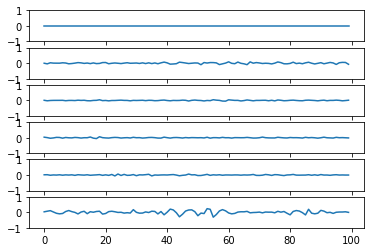

In [29]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x[3500,ch,:])
    plt.ylim(-1,1)
# plt.subplot(x_test_vae[0,0,:])

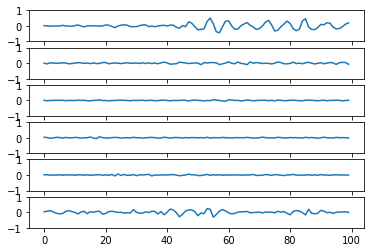

In [28]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x2[3500,ch,:])
    plt.ylim(-1,1)


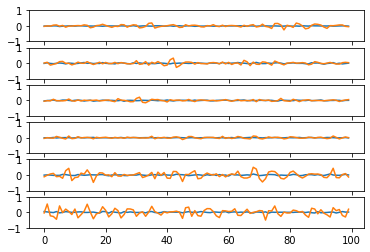

In [30]:
recon_inv = scaler.inverse_transform(recon.reshape(recon.shape[0],-1)).reshape(recon.shape)
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(recon_inv[3600,ch,:])
    plt.plot(x2[3600,ch,:])
    plt.ylim(-1,1)

In [22]:
bool = recon[3500,1,:] == x_1[3500,1,:]

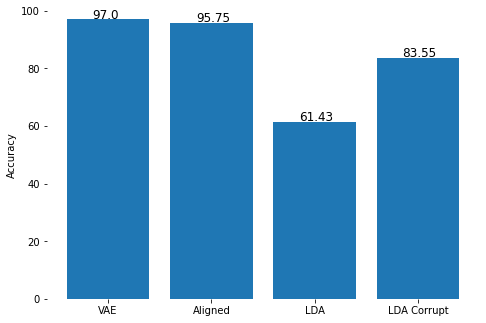

In [40]:
from scipy.stats import sem
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
temp = np.mean(acc_all[:6,:],axis=0)*100
ax.bar(['VAE','Aligned','LDA','LDA Corrupt'],temp)
ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
plt.box(on=None)
for i, v in enumerate(temp):
    ax.text(i-.15, v+.4, str(round(v,2)), color='black',fontsize=12)

# Transfer Learning

In [ ]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 25
feat_type = 'feat'
# data_in = norm_sub(feat_sq, params)

loo = np.ones([np.max(params[:,0]),1])
# loo[1,0] = 1

for sub in range(1,np.max(params[:,0])+1):
    for train_grp in range(3,4):#np.max(params[:,3])+1):
        foldername = 'models' + '_' + str(train_grp)

        if not os.path.exists(foldername):
            os.makedirs(foldername)


        filename = foldername + '/vae_grp4_lin_' + feat_type + '_AB' + str(sub)

        # Index EMG data
        x_train, y_train = sub_split(data_in,params,sub,train_grp)
        x_train_loo, y_train_loo = sub_split_loo(data_in,params,sub,train_grp)
        x_train, y_train = sub_split_stat(data_in,params,sub,train_grp)

        # Check if training data exists
        if (type(x_train) == np.ndarray) & (type(x_train_loo) == np.ndarray):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            
            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            scaler = MinMaxScaler(feature_range=(-1,1))
            x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)

            # Build VAE
            vae, encoder, decoder, clf = build_vae(latent_dim, input_type=feat_type)

            # # Fit and save VAE
            vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()
            clf_w = clf.get_weights()

            ## LEAVE ONE OUT SUPERVISED VAE
            if loo[sub-1,0]:
                # Scale data
                scaler_loo = MinMaxScaler(feature_range=(-1,1))
                x_train_loo = scaler_loo.fit_transform(x_train_loo.reshape(x_train_loo.shape[0],-1)).reshape(x_train_loo.shape)

                # Build VAE
                vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)

                # # Fit and save VAE
                vae_loo.fit(x_train_loo, {'clf': y_train_loo},epochs=epochs,batch_size=batch_size)
                vae_loo_w = vae_loo.get_weights()
                enc_loo_w = encoder_loo.get_weights()
                dec_loo_w = decoder_loo.get_weights()
                clf_loo_w = clf_loo.get_weights()

                loo[sub-1,0] = 0
            else:
                loo_file = 'models_3/vae_grp4_lin_' + feat_type + '_AB2'# + str(sub)
                with open(loo_file + '.p', 'rb') as f:
                    _, _, _, _, _, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, _, _, _, _, _, _, _, _, _, _ = pickle.load(f)

            ## BASELINE LDA
            # Train LDA classifier
            x_train_lda, y_train_lda = sub_split(feat, params, sub, train_grp)
            x_train_lda, y_train_lda = sub_split_stat(feat, params, sub, train_grp)
            w,c = train_lda(x_train_lda,y_train_lda)

            ## SUPERVISED VAE ALIGNED
            # Align
            # with open(filename + '.p', 'rb') as f:
            #     scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, w, c, w_aligned, c_aligned = pickle.load(f)

            # encoder.set_weights(enc_w)
            _, _, x_train_aligned = encoder.predict(x_train)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)

            ## PNN TEST
            vae_t, encoder_t, decoder_t, clf_t = build_pnn(vae_loo_w, latent_dim, input_type=feat_type)
            vae_t.fit(x_train, {'t_clf': y_train}, epochs=25,batch_size=batch_size)
            vae_t_w = vae_t.get_weights()
            enc_t_w = encoder_t.get_weights()
            dec_t_w = decoder_t.get_weights()
            clf_t_w = clf_t.get_weights()

            ## PNN ALIGNED
            _, _, x_train_aligned = encoder_t.predict(x_train)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            w_t, c_t = train_lda(x_train_aligned,y_train_aligned)

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, vae_t_w, enc_t_w, dec_t_w, clf_t_w, w, c, w_aligned,c_aligned, w_t, c_t],f)

In [ ]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 50

feat_type = 'feat'
data_in = feat_sq
# data_in = norm_sub(feat_sq,params)

sub_ave = np.zeros([6,1])
for sub in range(1,np.max(params[:,0])+1):
    for train_grp in range(3,4):#np.max(params[:,3])+1):
        foldername = 'models' + '_' + str(train_grp)
        filename = foldername + '/vae_grp4_lin_' + feat_type + '_AB' + str(sub)

        # Check if training data exists
        if os.path.exists(filename + '.p'):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            with open(filename + '.p', 'rb') as f:
                scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, vae_t_w, enc_t_w, dec_t_w, clf_t_w, w, c, w_aligned, c_aligned, w_t, c_t = pickle.load(f)
            # Build VAE
            vae, encoder, decoder, clf = build_vae(latent_dim, input_type=feat_type)
            vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)
            vae_t, encoder_t, decoder_t, clf_t = build_pnn(vae_loo_w, latent_dim, input_type=feat_type)

            ave_all = np.zeros([6,1])
            ave_count = 0
            for test_grp in range(3,4):#np.max(params[:,3])+1):
                # Index and scale test data
                x_test_raw, y_test = sub_split(data_in, params, sub, test_grp)
                if type(x_test_raw) == np.ndarray:
                    x_test = scaler.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)
                    x_test_loo = scaler_loo.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)

                    # Evaluate VAE predictions
                    vae.set_weights(vae_w)
                    y_pred, acc_vae = eval_vae(vae, x_test, y_test)

                    # Evaluate LDA predictions
                    x_test_lda, y_test_lda = sub_split(feat, params, sub, test_grp)
                    acc_lda = eval_lda(w, c, x_test_lda, y_test_lda)

                    # Evaluate LDA aligned predictions
                    encoder.set_weights(enc_w)
                    _, _, x_test_aligned = encoder.predict(x_test)
                    y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
                    acc_lda_aligned = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)

                    # Evaluate VAE-LOO predictions
                    vae_loo.set_weights(vae_loo_w)
                    y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_test)

                    # Evaluate PNN predictions
                    vae_t.set_weights(vae_t_w)
                    y_pred, acc_vae_t = eval_vae(vae_t, x_test, y_test)

                    # Evaluate PNN-LDA aligned predictions
                    encoder_t.set_weights(enc_t_w)
                    _, _, x_test_aligned = encoder_t.predict(x_test)
                    y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
                    acc_pnn_aligned = eval_lda(w_t, c_t, x_test_aligned, y_test_aligned)
                    
                    if (test_grp == 4) or (test_grp == 2):
                        ave_all += np.array([acc_vae, acc_lda, acc_lda_aligned, acc_vae_loo, acc_vae_t, acc_pnn_aligned]).reshape(6,1)
                        ave_count += 1
                    # print(ave_all)
                    print(str(test_grp) + ': vae - ' + "%.2f" % acc_vae + ', lda - ' + "%.2f" % acc_lda + ', lda aligned - ' 
                    + "%.2f" % acc_lda_aligned + ', vae loo - ' + "%.2f" % acc_vae_loo + ', pnn - ' + "%.2f" % acc_vae_t + ', pnn aligned - ' + "%.2f" % acc_pnn_aligned)
                    # print(str(test_grp) + ': lda - ' + "%.2f" % acc_lda + ', pnn - ' + "%.2f" % acc_vae_t + ', pnn aligned - ' + "%.2f" % acc_pnn_aligned)
            ave_all /= ave_count
            sub_ave += ave_all
sub_ave /=8
print(sub_ave)

In [ ]:
sub_ave*= 8
sub_ave/= 13
print(sub_ave)

In [ ]:
sub = 2
train_grp = 4
data_in = feat_sq
feat_type = 'feat'
latent_dim = 10
batch_size = 128

x_train_loo, y_train_loo = sub_split_loo(data_in,params,sub,train_grp)
scaler_loo = MinMaxScaler(feature_range=(-1,1))
x_train_loo = scaler_loo.fit_transform(x_train_loo.reshape(x_train_loo.shape[0],-1)).reshape(x_train_loo.shape)

# Build VAE
vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)

# # Fit and save VAE
vae_loo.fit(x_train_loo, {'clf': y_train_loo},epochs=100,batch_size=batch_size, validation_split = .1)
vae_loo_w = vae_loo.get_weights()
enc_loo_w = encoder_loo.get_weights()
dec_loo_w = decoder_loo.get_weights()
clf_loo_w = clf_loo.get_weights()

x_test_raw, y_test = sub_split(data_in, params, sub, train_grp)
x_test_loo = scaler_loo.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)
y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_train_loo)

In [ ]:
y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_test)
acc_vae_loo

In [ ]:
ave_all = np.zeros([6,1])
ave_all += np.array([1,2,3,4,5,6]).reshape(6,1)

In [ ]:
sub_ave*=14
sub_ave/=13
print()

In [ ]:
print(sub_ave)

In [ ]:
vae, encoder, decoder, clf = build_vae(12, input_type='feat')


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(vae, to_file='vae.png', show_shapes=True)


# Segment

In [ ]:
## INITIALIZE VARIABLES ##
# Data variables
sub = 14
train_grp = 2
test_grp = 3

# VAE hyperparameters
batch_size = 64
latent_dim = 10
epochs = 10
filename = 'vae_raw.h5'

In [ ]:
out, orig, sub_params = add_noise(raw,params,1)

In [ ]:
# Index EMG data
x_train, y_train, x_test, y_test = sub_train_test(raw,params,sub,train_grp,test_grp)

# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

# Build VAE
vae, encoder, decoder, clf = build_vae(latent_dim, input_type='raw')

# Fit and save VAE
vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
vae.save_weights(filename)

In [ ]:
# Index and scale test data
x_test, y_test = sub_split(raw, params, sub, test_grp)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

# Evaluate VAE predictions
y_pred, acc = eval_vae(vae, x_test, y_test)
print(acc)

In [ ]:
# Train LDA classifier
x_train_lda, y_train_lda, x_test_lda, y_test_lda = sub_train_test(feat, params, sub, train_grp, test_grp)
w,c = train_lda(x_train_lda,y_train_lda)

In [ ]:
# Evaluate LDA predictions
x_test_lda, y_test_lda = sub_split(feat, params, sub, test_grp)
out = predict(x_test_lda,w,c)
np.sum(out.reshape(y_test_lda.shape) == y_test_lda)/y_test_lda.shape[0]